In [119]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import re
from scipy.stats import sem
from sklearn.metrics import roc_auc_score,precision_recall_curve,precision_score, recall_score,matthews_corrcoef,roc_curve,confusion_matrix, ConfusionMatrixDisplay, accuracy_score
plt.rcParams['figure.dpi'] = 150
import warnings
from scipy.stats import fisher_exact

warnings.simplefilter(action='ignore', category=FutureWarning)
def get_msa(df):  
    msa = []
    for index, row in df.iterrows():
                i = int(row['Signal peptide'])
                msa.append(row['Sequence'][i-13:i+2])
    return msa
def get_pswm(msa):
    aa = 'ACDEFGHIKLMNPQRSTVWY'
    # Create a 13x20 matrix with all psceudocounts set to 1
    pspm = np.ones((15, 20))
    # let's count the aa freq by position
    for line in msa:
        for i in range(len(line)):
            if aa.find(line[i]) != -1:
                pspm[i,aa.find(line[i])] += 1
    #num_seq = #seq + 20
    num_seq=len(msa)  +20
    # normalize counts -> probabilities
    pspm = pspm/num_seq
    #only eucaryotes
    #swissprot_freq= np.array([0.0696, 0.0188, 0.0516, 0.0658, 0.0406, 0.0642, 0.0241, 0.0528, 0.0596, 0.0966, 0.0229, 0.0437, 0.0535, 0.0424, 0.0529, 0.0817, 0.0547, 0.062, 0.0124, 0.03])   
    #whole swissprot
    swissprot_freq = np.array([0.0825, 0.0138, 0.0546, 0.0672, 0.0386, 0.0707, 0.0227, 0.0591,0.058 , 0.0965, 0.0241, 0.0406, 0.0474, 0.0393, 0.0553, 0.0665,0.0536, 0.0685, 0.011 , 0.0292])
    pswm = np.ones((15, 20))
    for j in range(20):
        pswm[:,j] = np.round(np.log2(pspm[:,j]/swissprot_freq[j]),decimals=1)
    return pswm
def get_score(df,pswm):   
    aa = 'ACDEFGHIKLMNPQRSTVWY' 
    for index, row in df.iterrows():        
        seq = row['Sequence']
        if len(seq) >= 90:
            end_index = 90-15+1
        else:
            end_index = len(seq)-15+1        
        max_score = -999
        for n in range(end_index):
            score = 0
            for j in range(15):
                if aa.find(seq[j+n]) != -1:
                    score += pswm[j,aa.find(seq[j+n])]
            if score > max_score: max_score = score
        df.at[index,'score'] = max_score    
    return df
def get_heatmap(pswm):
    aa = 'ACDEFGHIKLMNPQRSTVWY'
    plt.figure(figsize=(7.5, 10))
    sns.set(font_scale=0.7)
    sns.heatmap(pswm.transpose(), cmap="RdBu", annot=True, yticklabels=aa,square=True,linewidths=0.2,cbar=False,xticklabels=np.array(range(15))-13)
    plt.title("PSSM Heatmap")
    plt.ylabel("")
    plt.xlabel("Position")
    return(plt.show())
def plot_confusion_matrix(cm, ax,xlabel,ylabel,cmap):
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, ax=ax)
    if xlabel==True:
        ax.set_xlabel('Predicted')
        ax.set_xticklabels(['-', '+'])
    else:
        ax.set_xlabel('')
        ax.set_xticklabels(['', ''])
    if ylabel==True:
        ax.set_ylabel('Actual')
        ax.set_yticklabels(['-', '+'])
    else:
        ax.set_ylabel('')
        ax.set_yticklabels(['', ''])

### Training set preparation 

In [120]:
training = pd.read_table('../stats/training_metadata_parsed.tsv')[["Entry", "Signal peptide","Sequence"]]
#shuffle rows 
training = training.sample(frac=1, random_state=3)
training['score'] = np.nan
training['class'] = 0
training.loc[training['Signal peptide'].notna(), 'class'] = 1
#split + and - in 2 df
positives = training.loc[training['class'] == 1,]
negatives = training.loc[training['class'] == 0,]
#count the num of entries
num_negatives = negatives.shape[0]
num_positives = positives.shape[0]
#positives=np.array(positives)
positives = np.array_split(positives,5)
negatives = np.array_split(negatives,5)
    


### Save dataset ID, seq, SP, set, cv_subset in a file

In [121]:
for i in range(5):
    positives[i]['set'] = 'training'
    negatives[i]['set'] = 'training'
    positives[i]['cv_subset'] = i
    negatives[i]['cv_subset'] = i



benchmark = pd.read_table('../stats/benchmark_metadata_parsed.tsv')[["Entry", "Signal peptide","Sequence"]]
benchmark['class'] = 0
benchmark.loc[benchmark['Signal peptide'].notna(), 'class'] = 1
benchmark['set']='benchmarking'
benchmark['cv_subset']=''
benchmark = benchmark[['Entry','Sequence','class','set','cv_subset']]
training2 = pd.concat((positives[0],negatives[0]),ignore_index=True)
for i in range(1,5):
    training2 = pd.concat((training2,positives[i],negatives[i]),ignore_index=True)
training2 = training2[['Entry','class','set','cv_subset','Sequence']]

final_df = pd.concat((training2,benchmark),ignore_index=True)
final_df.to_csv('../../dataset.tsv',sep='\t',index=False)


### SP length distribution by subset

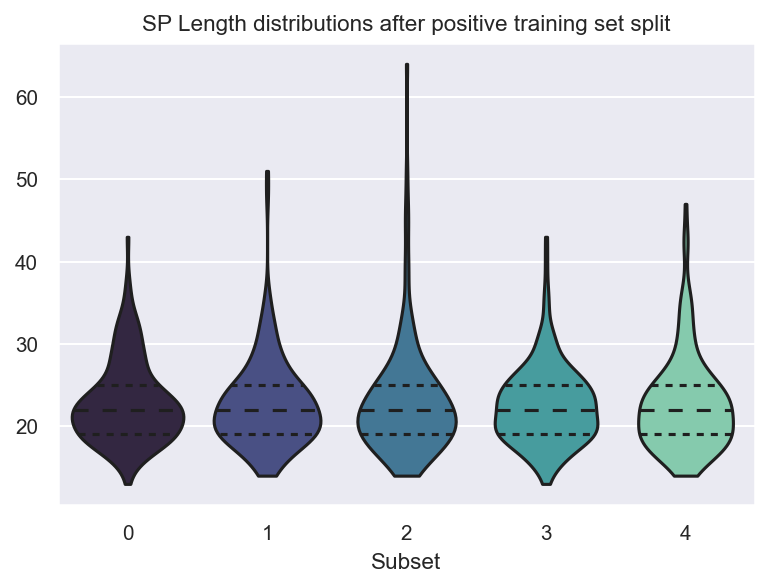

In [122]:
palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=False)

sp_len = []
for i in range(5):
    sp_len.append(positives[i]['Signal peptide'])
plt.figure(figsize=(6, 4))
ax = sns.violinplot(data=sp_len, palette='mako', inner='quart', cut = 0).set(xlabel='Subset')
plt.title('SP Length distributions after positive training set split')
plt.savefig("figures/sp_len_cv_split.svg")


### Training and CV

In [123]:
# training    validation    test      benchmark
# 0,1,2       3             4         benchmark tsv
# 1,2,3       4             0         benchmark tsv
# .....    .....         ...          benchmark tsv
prcs = pd.DataFrame(columns=['run', 'precision', 'recall'])
rocs = pd.DataFrame(columns=['run', 'fpr', 'tpr'])
validation_metrics = []
test_metrics = []

for run in range(5):
    pswm = get_pswm(get_msa(pd.concat((positives[(0+run)%5],positives[(1+run)%5],positives[(2+run)%5]),ignore_index=True)))
    validation = pd.concat((positives[(3+run)%5],negatives[(3+run)%5]),ignore_index=True)
    test = pd.concat((positives[(4+run)%5],negatives[(4+run)%5]),ignore_index=True)
    #crossvalidation
    validation = get_score(validation,pswm)
    precisions, recalls, thresholds = precision_recall_curve(validation['class'], validation['score'])
    fpr, tpr, roc_thresholds = roc_curve(validation['class'], validation['score'])
    f1scores = (2 * precisions * recalls) / (precisions + recalls)
    index = np.argmax(f1scores)
    optimal_threshold = thresholds[index]
    f1score = f1scores[index]
    precision = precisions[index]
    recall = recalls[index]
    mcc = matthews_corrcoef(validation['class'], validation['score'] > optimal_threshold)
    cm = confusion_matrix(validation['class'], validation['score'] > optimal_threshold)
    auc = roc_auc_score(validation['class'], validation['score'])
    acc = accuracy_score(validation['class'], validation['score']> optimal_threshold)

    validation_metrics.append([run,optimal_threshold,auc,precision,recall,f1score,mcc,cm,acc])
    #
    prc = {'run': run, 'precision':precisions, 'recall':recalls}
    roc = {'run': run, 'fpr':fpr, 'tpr':tpr}
    prc = pd.DataFrame(prc)
    roc = pd.DataFrame(roc)
    prcs = pd.concat((prcs,prc),ignore_index=True)
    rocs = pd.concat((rocs,roc),ignore_index=True)
    #testing
    test = get_score(test,pswm)
    test['pred_class'] = 0
    test.loc[test['score']>optimal_threshold, 'pred_class'] = 1
    precision = precision_score(test['class'], test['pred_class'])
    recall= recall_score(test['class'], test['pred_class'])
    f1score = (2 * precision * recall) / (precision + recall)
    mcc = matthews_corrcoef(test['class'], test['pred_class'])
    acc = accuracy_score(test['class'], test['pred_class'])
    cm = confusion_matrix(test['class'], test['pred_class'])
    test_metrics.append([run,optimal_threshold,precision,recall,f1score,mcc,cm,acc])
    # save tsv of test subset
    
    test[['Entry','class','pred_class']].to_csv('cv_subsets/test_subset_'+str(run)+'.tsv',sep='\t',index=False)

validation_metrics = pd.DataFrame(validation_metrics)
validation_metrics.columns = ['run','optimal_threshold','auc','precision','recall','f1score','MCC','cm','ACC']
test_metrics = pd.DataFrame(test_metrics)
test_metrics.columns = ['run','optimal_threshold','precision','recall','f1score','MCC','cm','ACC']


### Results

In [124]:
validation_metrics.to_pickle('validation_metrics.pkl')
test_metrics.to_pickle('test_metrics.pkl')
test

,Entry,Signal peptide,Sequence,score,class,set,cv_subset,pred_class
0,Q94K85,26.0,MAVYNTKLCLASVFLLLGLLLAFDLKGIEAESLTKQKLDSKILQDE...,10.2,1,training,3,1
1,P05560,23.0,MTMASVLVLLSLVLCCFPDTAFGVEVDCSKYPNTTNEDGKEVLLCP...,12.9,1,training,3,1
2,P26842,19.0,MARPHPWWLCVLGTLVGLSATPAPKSCPERHYWAQGKLCCQMCEPG...,10.4,1,training,3,1
3,P08603,18.0,MRLLAKIICLMLWAICVAEDCNELPPRRNTEILTGSWSDQTYPEGT...,6.5,1,training,3,0
4,Q29W25,26.0,MGKCQAVFLLVGALCVLSLAGVANAAENHFKVQGMVYCDTCRIQFM...,16.1,1,training,3,1
...,...,...,...,...,...,...,...,...
1693,Q8TEX9,NaN,MESAGLEQLLRELLLPDTERIRRATEQLQIVLRAPAALPALCDLLA...,9.2,0,training,3,1
1694,Q03111,NaN,MDNQCTVQVRLELGHRAQLRKKPTTEGFTHDWMVFVRGPEQCDIQH...,-2.9,0,training,3,0
1695,Q5BPF3,NaN,MASQWTIPKLVTWRVRDWASCFLACKIPLDGDEDGANNNGNTTNNN...,2.6,0,training,3,0
1696,P28370,NaN,MEQDTAAVAATVAAADATATIVVIEDEQPGPSTSQEEGAAAAATEA...,6.7,0,training,3,0


In [125]:
print(validation_metrics)

   run  optimal_threshold       auc  precision    recall   f1score       MCC   
0    0                9.6  0.962523   0.756250  0.691429  0.722388  0.688915  \
1    1                8.4  0.962819   0.680000  0.781609  0.727273  0.687983   
2    2                9.7  0.966018   0.810458  0.708571  0.756098  0.731141   
3    3                9.2  0.953369   0.735294  0.714286  0.724638  0.685641   
4    4                9.1  0.966852   0.694301  0.765714  0.728261  0.690783   

                        cm       ACC  
0  [[1484, 39], [55, 120]]  0.944641  
1  [[1459, 64], [40, 134]]  0.938715  
2  [[1496, 28], [52, 123]]  0.952913  
3  [[1479, 45], [52, 123]]  0.942908  
4  [[1466, 58], [43, 132]]  0.940553  


In [126]:
print(test_metrics)

   run  optimal_threshold  precision    recall   f1score       MCC   
0    0                9.6   0.777778  0.643678  0.704403  0.677819  \
1    1                8.4   0.681159  0.805714  0.738220  0.708482   
2    2                9.7   0.808219  0.674286  0.735202  0.711370   
3    3                9.2   0.677083  0.742857  0.708447  0.674139   
4    4                9.1   0.711957  0.748571  0.729805  0.698162   

                        cm       ACC  
0  [[1491, 32], [62, 112]]  0.944608  
1  [[1458, 66], [34, 141]]  0.941142  
2  [[1496, 28], [57, 118]]  0.949971  
3  [[1462, 62], [45, 130]]  0.937022  
4  [[1470, 53], [44, 131]]  0.942874  


### Precision-Recall Curve by run


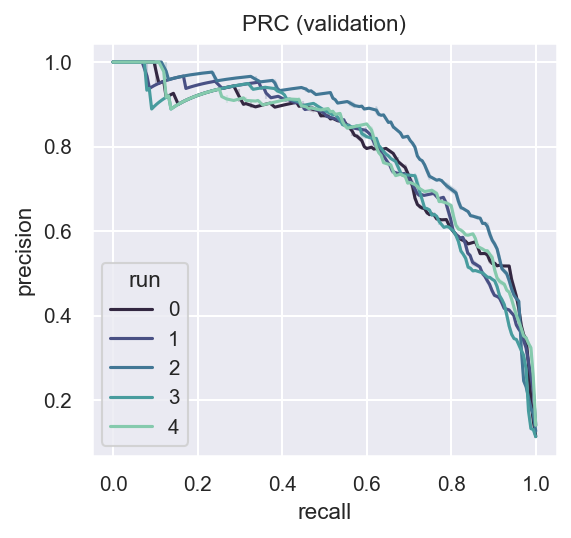

In [127]:
mako = ["#332741","#495084","#427795","#489c9e","#85caad"]
sns.set_style("darkgrid")
plt.figure(figsize=(4, 4))
sns.lineplot(data=prcs,x='recall',y='precision',palette=mako,hue='run')
plt.title("PRC (validation)")
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("figures/prc_val.svg")

### ROC


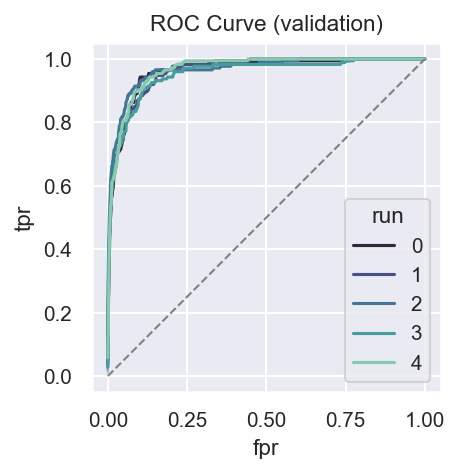

In [128]:
sns.lineplot(data=rocs,x='fpr',y='tpr',hue='run',palette=mako)
plt.title("ROC Curve (validation)")
plt.gca().set_aspect('equal', adjustable='box')
x = np.linspace(0, 1, 1000)
plt.plot(x, x + 0, linestyle='--',color='grey',linewidth=1)
plt.grid(linestyle='-')
plt.savefig("figures/roc_val.svg")

### PSWM matrix built on the whole training set of positives


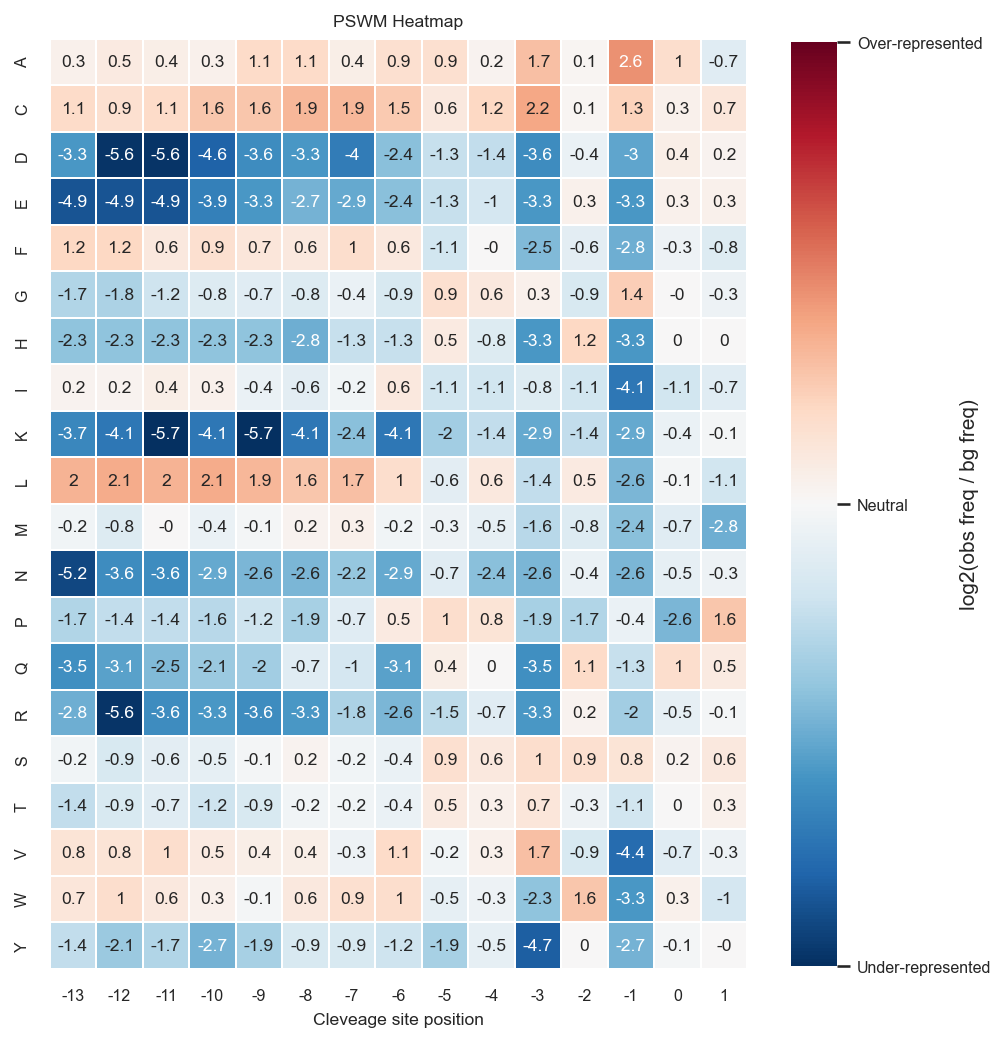

In [129]:
positives = training.loc[training['class'] == 1,]
pswm = get_pswm(get_msa(positives))
np.save('pswm.npy', pswm)
plt.figure(figsize=(7.5, 10))
sns.set(font_scale=0.7)
aa = 'ACDEFGHIKLMNPQRSTVWY'
ax = sns.heatmap(pswm.transpose(), cmap="RdBu_r", center = 0,vmin=-5.7,vmax=5.7,annot=True, yticklabels=aa,square=True,linewidths=0.2,xticklabels=np.array(range(15))-13,cbar_kws={'shrink': 0.8})
plt.title("PSWM Heatmap")
plt.ylabel("")
plt.xlabel("Cleveage site position")
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([-5.7, 0, 5.7])
c_bar.set_ticklabels(['Under-represented', 'Neutral', 'Over-represented'])
c_bar.set_label('log2(obs freq / bg freq)', labelpad=-15, fontsize=10)
plt.savefig("figures/pswm.svg")


### Benchmark 


In [130]:
test_metrics = pd.read_pickle('test_metrics.pkl')
optimal_threshold = test_metrics['optimal_threshold'].mean()
benchmark = pd.read_table('../stats/benchmark_metadata_parsed.tsv')[["Entry", "Signal peptide","Sequence"]]
benchmark['score'] = np.nan
benchmark['class'] = 0
benchmark.loc[benchmark['Signal peptide'].notna(), 'class'] = 1
benchmark.shape[0]

benchmark = get_score(benchmark,pswm)
benchmark['pred_class'] = 0
benchmark.loc[benchmark['score']>optimal_threshold, 'pred_class'] = 1
precision = precision_score(benchmark['class'], benchmark['pred_class'])
recall= recall_score(benchmark['class'], benchmark['pred_class'])
f1score = (2 * precision * recall) / (precision + recall)
mcc = matthews_corrcoef(benchmark['class'], benchmark['pred_class'])
cm = confusion_matrix(benchmark['class'], benchmark['pred_class'])
acc = accuracy_score(benchmark['class'], benchmark['pred_class'])
benchmark_metrics = [optimal_threshold,precision,recall,f1score,mcc,acc,cm]
#save
benchmark[['Entry','class','pred_class']].to_csv('benchmark.tsv',sep='\t',index=False)



### Metrics comparison

In [131]:
test_avg = test_metrics[['optimal_threshold','precision', 'recall', 'f1score', 'MCC','ACC']].mean()
test_se = test_metrics[['optimal_threshold','precision', 'recall', 'f1score', 'MCC','ACC']].sem()
# Create a new DataFrame with the desired format
result_df = pd.DataFrame({
    'metric': ['optimal_threshold', 'precision', 'recall', 'f1score', 'MCC','ACC'],
    'test': [f'{avg:.2f} ± ({std:.2f})' for avg, std in zip(test_avg, test_se)],
    'benchmark': [f'{el:.2f}' for el in benchmark_metrics[:-1]]})

#Set the 'metric' column as the index
result_df.set_index('metric', inplace=True)
result_df = result_df.transpose()[:][:]
result_df.columns = ['optimal_threshold', 'precision', 'recall', 'f1score', 'MCC','ACC']
result_df.to_csv('results.tsv',sep='\t')
result_df

,optimal_threshold,precision,recall,f1score,MCC,ACC
test,9.20 ± (0.23),0.73 ± (0.03),0.72 ± (0.03),0.72 ± (0.01),0.69 ± (0.01),0.94 ± (0.00)
benchmark,9.20,0.71,0.72,0.72,0.68,0.94


In [132]:
test_metrics['set']='test'
melted = test_metrics.melt(id_vars=['set'], value_vars=['precision', 'recall', 'f1score', 'MCC','ACC'],var_name='metric', value_name='value')
benchmark_scores = {'precision':benchmark_metrics[1], 'recall':benchmark_metrics[2], 'f1score':benchmark_metrics[3], 'MCC':benchmark_metrics[4], 'ACC':benchmark_metrics[5]}
benchmark_scores = pd.DataFrame(list(benchmark_scores.items()), columns=['metric', 'value'])
benchmark_scores['set'] = 'benchmark'
melted = pd.concat((melted,benchmark_scores),ignore_index = True)

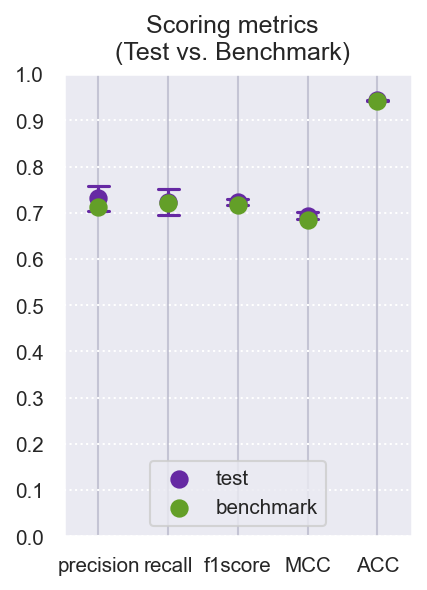

In [133]:
plt.figure(figsize=(3, 4))
plt.suptitle('Scoring metrics\n(Test vs. Benchmark)',size=12)
sns.set(font_scale=0.9)
sns.set_style("darkgrid")
sns.pointplot(data=melted,x='metric',y='value',hue='set',join=False,palette=["#6629A3","#639F28"],errorbar='se',errwidth=1.5,capsize=0.3).set(
    ylim=(0, 1),ylabel='',xlabel='',yticks=[0.1 * i for i in range(11)],)
plt.grid(axis='x',color='#C4C4D4', linestyle='-', linewidth=1)
plt.grid(axis='y',color='white', linestyle=':', linewidth=1)
plt.legend(loc='lower center')
plt.savefig("figures/metrics.svg")



### Confusion matrices (test set) for each run

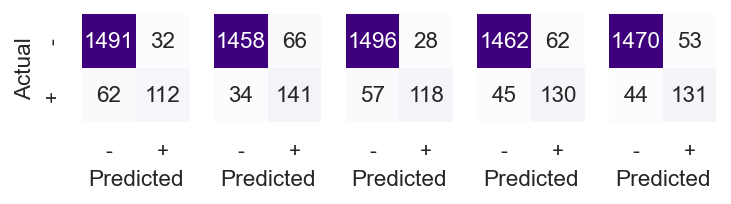

In [134]:


fig, axes = plt.subplots(1, len(test_metrics), figsize=(5, 1.5))
for i, row in test_metrics.iterrows():
    cm = np.array(row['cm'])
    if i == 0:
        plot_confusion_matrix(cm, axes[i],True,True,'Purples')
    else:
        plot_confusion_matrix(cm, axes[i],True,False,'Purples')
    axes[i].set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/confusiomatrices_test.svg")

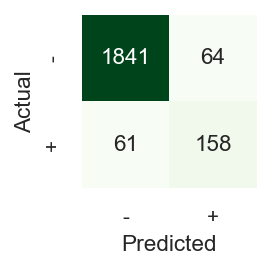

In [135]:
cm = np.array(benchmark_metrics[6])
plt.figure(figsize=(1.5, 1.5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', cbar=False).set(xticklabels=['-', '+'],yticklabels=['-', '+'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("figures/confusion_matrices_benchmark.svg", bbox_inches='tight')




In [136]:
61/(61+158)

0.2785388127853881

# FP analysis

### Download negatives as json and store them in a file to do the filtering

In [137]:
#import requests, sys
import json
#def get_json_by_accession(accession):
#        requestURL = "https://www.ebi.ac.uk/proteins/api/proteins/%s" % accession
#        r = requests.get(requestURL, headers={ "Accept" : "application/json"})
#        if not r.ok:
#            r.raise_for_status()
#        json_body = r.json()
#        return json_body 
#
##save the json in a file text
#with open('fp_analysis/benchmarking_neg', 'r') as f1, open('fp_analysis/json.list','x') as f2:
#    for entry in f1:
#        entry = entry.rstrip()
#        json_data = get_json_by_accession(entry)
#        f2.write(json.dumps(json_data)  +'\n')

### Filter only Transmembrane proteins (ECOs manually annotated) with region pos <90

In [138]:
eco_lst = ['ECO:0000269', 'ECO:0000303', 'ECO:0000305', 'ECO:0000250', 'ECO:0000255', ' ECO:0000312', ' ECO:0007744']
with open('fp_analysis/json.list') as jsonlist, open('fp_analysis/transmembrane_proteins.list','w') as tm:
    for line in jsonlist:
        line = line.rstrip()
        data = json.loads(line)
        entry = data['accession']
        tm_found = False
        for item in data['features']:
            
            if tm_found: break
            elif item['type'] == 'TRANSMEM' and item['begin'] == '<1':
                try:
                    for e in item['evidences']:
                        if e['code'] in eco_lst:
                            tm.write(entry+'\n')
                            tm_found = True
                            break      
                except KeyError:
                    print('No ECO term for %s' % entry)
            elif item['type'] == 'TRANSMEM' and int(item['begin']) < 90:                  
                try:
                    for e in item['evidences']:
                        if e['code'] in eco_lst:
                            tm.write(entry+'\n')
                            tm_found = True
                            break      
                except KeyError:
                    print('No ECO term for %s' % entry)


No ECO term for P49728
No ECO term for Q63707


### Filter only proteins with Transt peptide (ECOs manually annotated) in pos <90

In [139]:
eco_lst = ['ECO:0000269', 'ECO:0000303', 'ECO:0000305', 'ECO:0000250', 'ECO:0000255', ' ECO:0000312', ' ECO:0007744']
with open('fp_analysis/json.list') as jsonlist, open('fp_analysis/transpeptide_proteins.list','w') as tp:
    for line in jsonlist:
        line = line.rstrip()
        data = json.loads(line)
        entry = data['accession']
        tp_found = False
        for item in data['features']:
            if tp_found: break
            elif item['type'] == 'TRANSIT' and item['begin'] == '<1':
                try:
                    for e in item['evidences']:
                        if e['code'] in eco_lst:
                            
                            tp.write(entry+'\t'+item['description']+'\n')
                            break      
                except KeyError:
                    print('No ECO term for %s' % entry)
            elif item['type'] == 'TRANSIT' and int(item['begin']) < 90:                  
                try:
                    for e in item['evidences']:
                        if e['code'] in eco_lst:
                            
                            tp.write(entry+'\t'+item['description']+'\n')
                            tp_found = True
                            break      
                except KeyError:
                    print('No ECO term for %s' % entry)

No ECO term for Q9NGX9
No ECO term for P79089
No ECO term for Q8R104
No ECO term for P11178
No ECO term for O42637
No ECO term for Q84K96
No ECO term for P40008
No ECO term for P23786
No ECO term for Q5YLB5
No ECO term for P53077
No ECO term for P37225
No ECO term for P10109
No ECO term for Q63707


## Compute FPR inside the TM(Transmembrane) and TP(Transit peptide) subsets

In [140]:
#save negative to do fp
benchmark[benchmark['class']==0][['Entry','class','pred_class']].to_csv('benchmark_negative.tsv',sep='\t',index=False)
fpr = np.round(cm[0][1]/(cm[0][1]+cm[0][0]),decimals=3)
print('General FPR: %s' % (fpr*100)+'%')


General FPR: 3.4000000000000004%


In [141]:
benchmark_neg = benchmark[benchmark['class']==0][['Entry','pred_class']]
benchmark_neg['TM']=0

with open('fp_analysis/transmembrane_proteins.list') as file:
    tm_subset = [line.strip() for line in file]
benchmark_neg['TM'] = benchmark_neg['Entry'].isin(tm_subset).astype(int)

tp_subset = pd.read_table('fp_analysis/transpeptide_proteins.list',sep='\t',names=['Entry','TP_location'])
benchmark_neg = pd.merge(benchmark_neg,tp_subset,on='Entry',how = 'outer')
benchmark_neg.insert(loc=3, column='TP', value=0)
benchmark_neg.loc[benchmark_neg['TP_location'].notna(), 'TP'] = 1
benchmark_neg

,Entry,pred_class,TM,TP,TP_location
0,Q9UT72,0,0,0,NaN
1,P30397,0,0,0,NaN
2,P25398,0,0,0,NaN
3,O15554,1,1,0,NaN
4,Q8IWZ6,0,0,0,NaN
...,...,...,...,...,...
1900,Q8VY77,0,1,0,NaN
1901,Q86X29,1,0,0,NaN
1902,Q7SHB2,1,0,0,NaN
1903,Q9H2W6,0,0,1,Mitochondrion


### FPR_TM

In [142]:
tm_FP = benchmark_neg[(benchmark_neg['TM']==1) & (benchmark_neg['pred_class']==1)].shape[0]
tm = benchmark_neg[(benchmark_neg['TM']==1)].shape[0]
FPR_tm =np.round((tm_FP/tm)*100,decimals=2)
print('FPR_TM: %s' % (FPR_tm)+'%')

#

FPR_TM: 18.75%


### FPR_TP

In [143]:
tp_FP = benchmark_neg[(benchmark_neg['TP']==1) & (benchmark_neg['pred_class']==1)].shape[0]
tp = benchmark_neg[(benchmark_neg['TP']==1)].shape[0]
FPR_tp =np.round((tp_FP/tp)*100,decimals=1)
print('FPR_TP: %s' % (FPR_tp)+'%')


FPR_TP: 4.6%


### FPR_TM and FPR_TP visualization

In [144]:
benchmark_neg.loc[benchmark_neg['pred_class'] == 1,'pred_class']='FP'
benchmark_neg.loc[benchmark_neg['pred_class'] == 0,'pred_class']='TN'
################################################################################################
tm_df = benchmark_neg[benchmark_neg['TM']==1][['pred_class','TM']]
tm_df['feature'] = 'Transmembrane'
#
tp_df = benchmark_neg[benchmark_neg['TP']==1][['pred_class','TP']]
tp_df['feature'] = 'Transit peptide'
#
tm_tp = pd.concat((tm_df[['pred_class','feature']],tp_df[['pred_class','feature']]),ignore_index=True)
tm_tp

,pred_class,feature
0,FP,Transmembrane
1,FP,Transmembrane
2,TN,Transmembrane
3,TN,Transmembrane
4,TN,Transmembrane
...,...,...
373,FP,Transit peptide
374,TN,Transit peptide
375,TN,Transit peptide
376,TN,Transit peptide


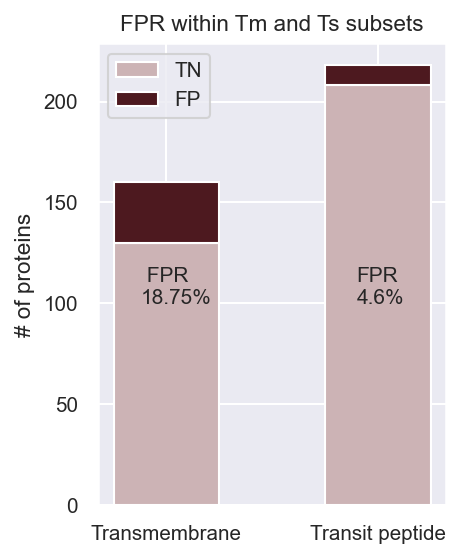

In [145]:
palette = {"TN":"#CCB3B5","FP":"#4D191F"}
sns.set_style("darkgrid")
plt.figure(figsize=(3, 4))
sns.histplot(data=tm_tp,x = 'feature',hue='pred_class',alpha=1,stat='count',multiple='stack',common_norm=False,shrink=0.5,palette=palette).set(title='FPR within Tm and Ts subsets',xlabel='',ylabel='# of proteins')
plt.legend(title='', labels=['TN', 'FP'])
plt.text(-0.12, 100, f' FPR\n{FPR_tm}%', fontsize=10)
plt.text(0.9, 100, f'FPR\n{FPR_tp}%', fontsize=10)
plt.savefig("figures/FPR_TMandFPR_TP.svg", bbox_inches='tight')

### Over-representation of transmembrane proteins in FP with respect to TN

In [146]:
benchmark_neg.loc[benchmark_neg['TM'] == 1,'TM']='Transmembrane'
benchmark_neg.loc[benchmark_neg['TM'] == 0,'TM']='Non-Transmembrane'
benchmark_neg.loc[benchmark_neg['TP'] == 1,'TP']='Transit peptide'
benchmark_neg.loc[benchmark_neg['TP'] == 0,'TP']='Non-Transit peptide'

In [147]:
pivot_df = benchmark_neg.pivot_table(index='pred_class', columns='TM', values='Entry', aggfunc='count', fill_value=0)
columns_titles = ['Transmembrane',"Non-Transmembrane"] #change cols order
pivot_df = pivot_df.reindex(columns=columns_titles)
OR, p_val = fisher_exact(pivot_df,alternative='greater')
p_val = '{:0.2e}'.format(p_val)

# 
pivot_df['Total'] = pivot_df['Transmembrane'] + pivot_df['Non-Transmembrane']
pivot_df['Transmembrane_Percentage'] = (pivot_df['Transmembrane'] / pivot_df['Total']) * 100
pivot_df['Non_transmembrane_Percentage'] = (pivot_df['Non-Transmembrane'] / pivot_df['Total']) * 100

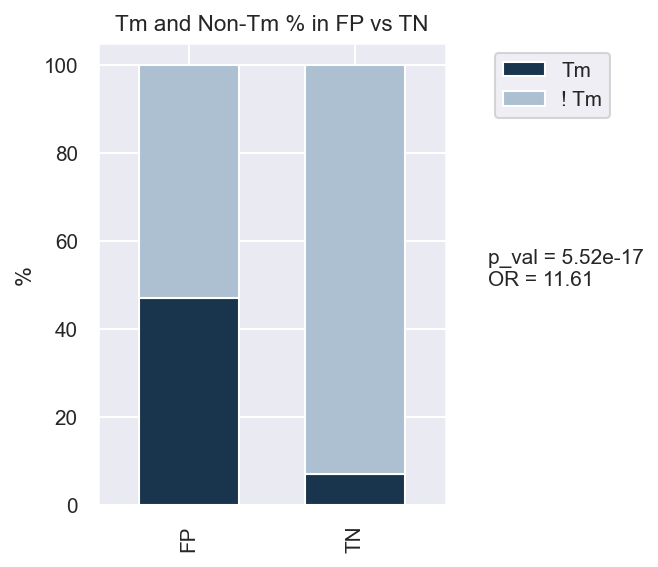

In [148]:
from matplotlib.colors import ListedColormap

pivot_df = pivot_df[['Transmembrane_Percentage', 'Non_transmembrane_Percentage']]
palette = ['#19344D','#ACC0D2'] 
palette = ListedColormap(sns.color_palette(palette))
# Create the stacked barplot
plt.rcParams['figure.figsize'] = [3, 4]
pivot_df[['Transmembrane_Percentage', 'Non_transmembrane_Percentage']].plot(kind='bar', stacked=True, colormap=palette,width=0.6)
plt.title('Tm and Non-Tm % in FP vs TN')
plt.xlabel('')
plt.ylabel('%')
plt.legend(title='', loc='upper right', labels=['Tm', '! Tm'], bbox_to_anchor=(1.5, 1))
plt.text(1.8, 50, f'p_val = {p_val}\nOR = {OR:.2f}', fontsize=10)
plt.savefig("figures/ORofTMinFP.svg", bbox_inches='tight')


### Over-representation of transit peptide proteins in FP with respect to TN

In [149]:
pivot_df2 = benchmark_neg.pivot_table(index='pred_class', columns='TP', values='Entry', aggfunc='count', fill_value=0)
#
columns_titles = ['Transit peptide',"Non-Transit peptide"]
pivot_df2=pivot_df2.reindex(columns=columns_titles)
OR, p_val = fisher_exact(pivot_df2,alternative='greater')

# 
pivot_df2['Total'] = pivot_df2['Transit peptide'] + pivot_df2['Non-Transit peptide']
pivot_df2['Transit peptide_Percentage'] = (pivot_df2['Transit peptide'] / pivot_df2['Total']) * 100
pivot_df2['Non_Transit-peptide_Percentage'] = (pivot_df2['Non-Transit peptide'] / pivot_df2['Total']) * 100
pivot_df2

TP,Transit peptide,Non-Transit peptide,Total,Transit peptide_Percentage,Non_Transit-peptide_Percentage
pred_class,,,,,
FP,10,54,64,15.625000,84.375000
TN,208,1633,1841,11.298207,88.701793


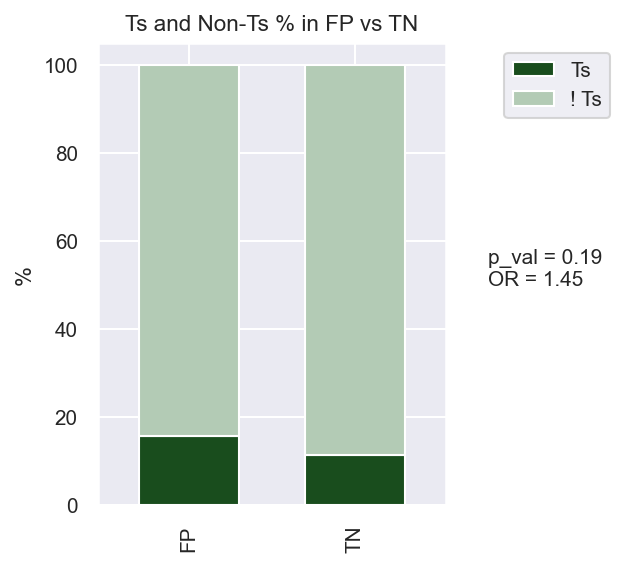

In [150]:
pivot_df = pivot_df[['Transmembrane_Percentage', 'Non_transmembrane_Percentage']]
palette = ['#194D1D','#B3CBB5']
palette = ListedColormap(sns.color_palette(palette))
#
plt.rcParams['figure.figsize'] = [3, 4]
pivot_df2[['Transit peptide_Percentage', 'Non_Transit-peptide_Percentage']].plot(kind='bar', stacked=True, colormap=palette,width=0.6)
plt.title('Ts and Non-Ts % in FP vs TN')
plt.xlabel('')
plt.ylabel('%')
plt.legend(title='', labels=['Ts', '! Ts'], bbox_to_anchor=(1.5, 1))
plt.text(1.8, 50, f'p_val = {p_val:.2f}\nOR = {OR:.2f}', fontsize=10)
plt.savefig("figures/ORofTPinFP.svg", bbox_inches='tight')


## FN sequence logo

In [151]:
fn_df = benchmark[(benchmark['class'] == 1) & (benchmark['pred_class'] == 0)]
with open('fn.msa','w') as file:
    for index, row in fn_df.iterrows():
        if not pd.isna(row['Signal peptide']):
            i = int(row['Signal peptide'])
            file.write(row['Sequence'][i-13:i+2]+'\n')
fnr = np.round(cm[1][0]/(cm[1][1]+cm[1][0]),decimals=3)
print('FNR: %s' % (fnr*100)+'%')

FNR: 27.900000000000002%


## FN logo

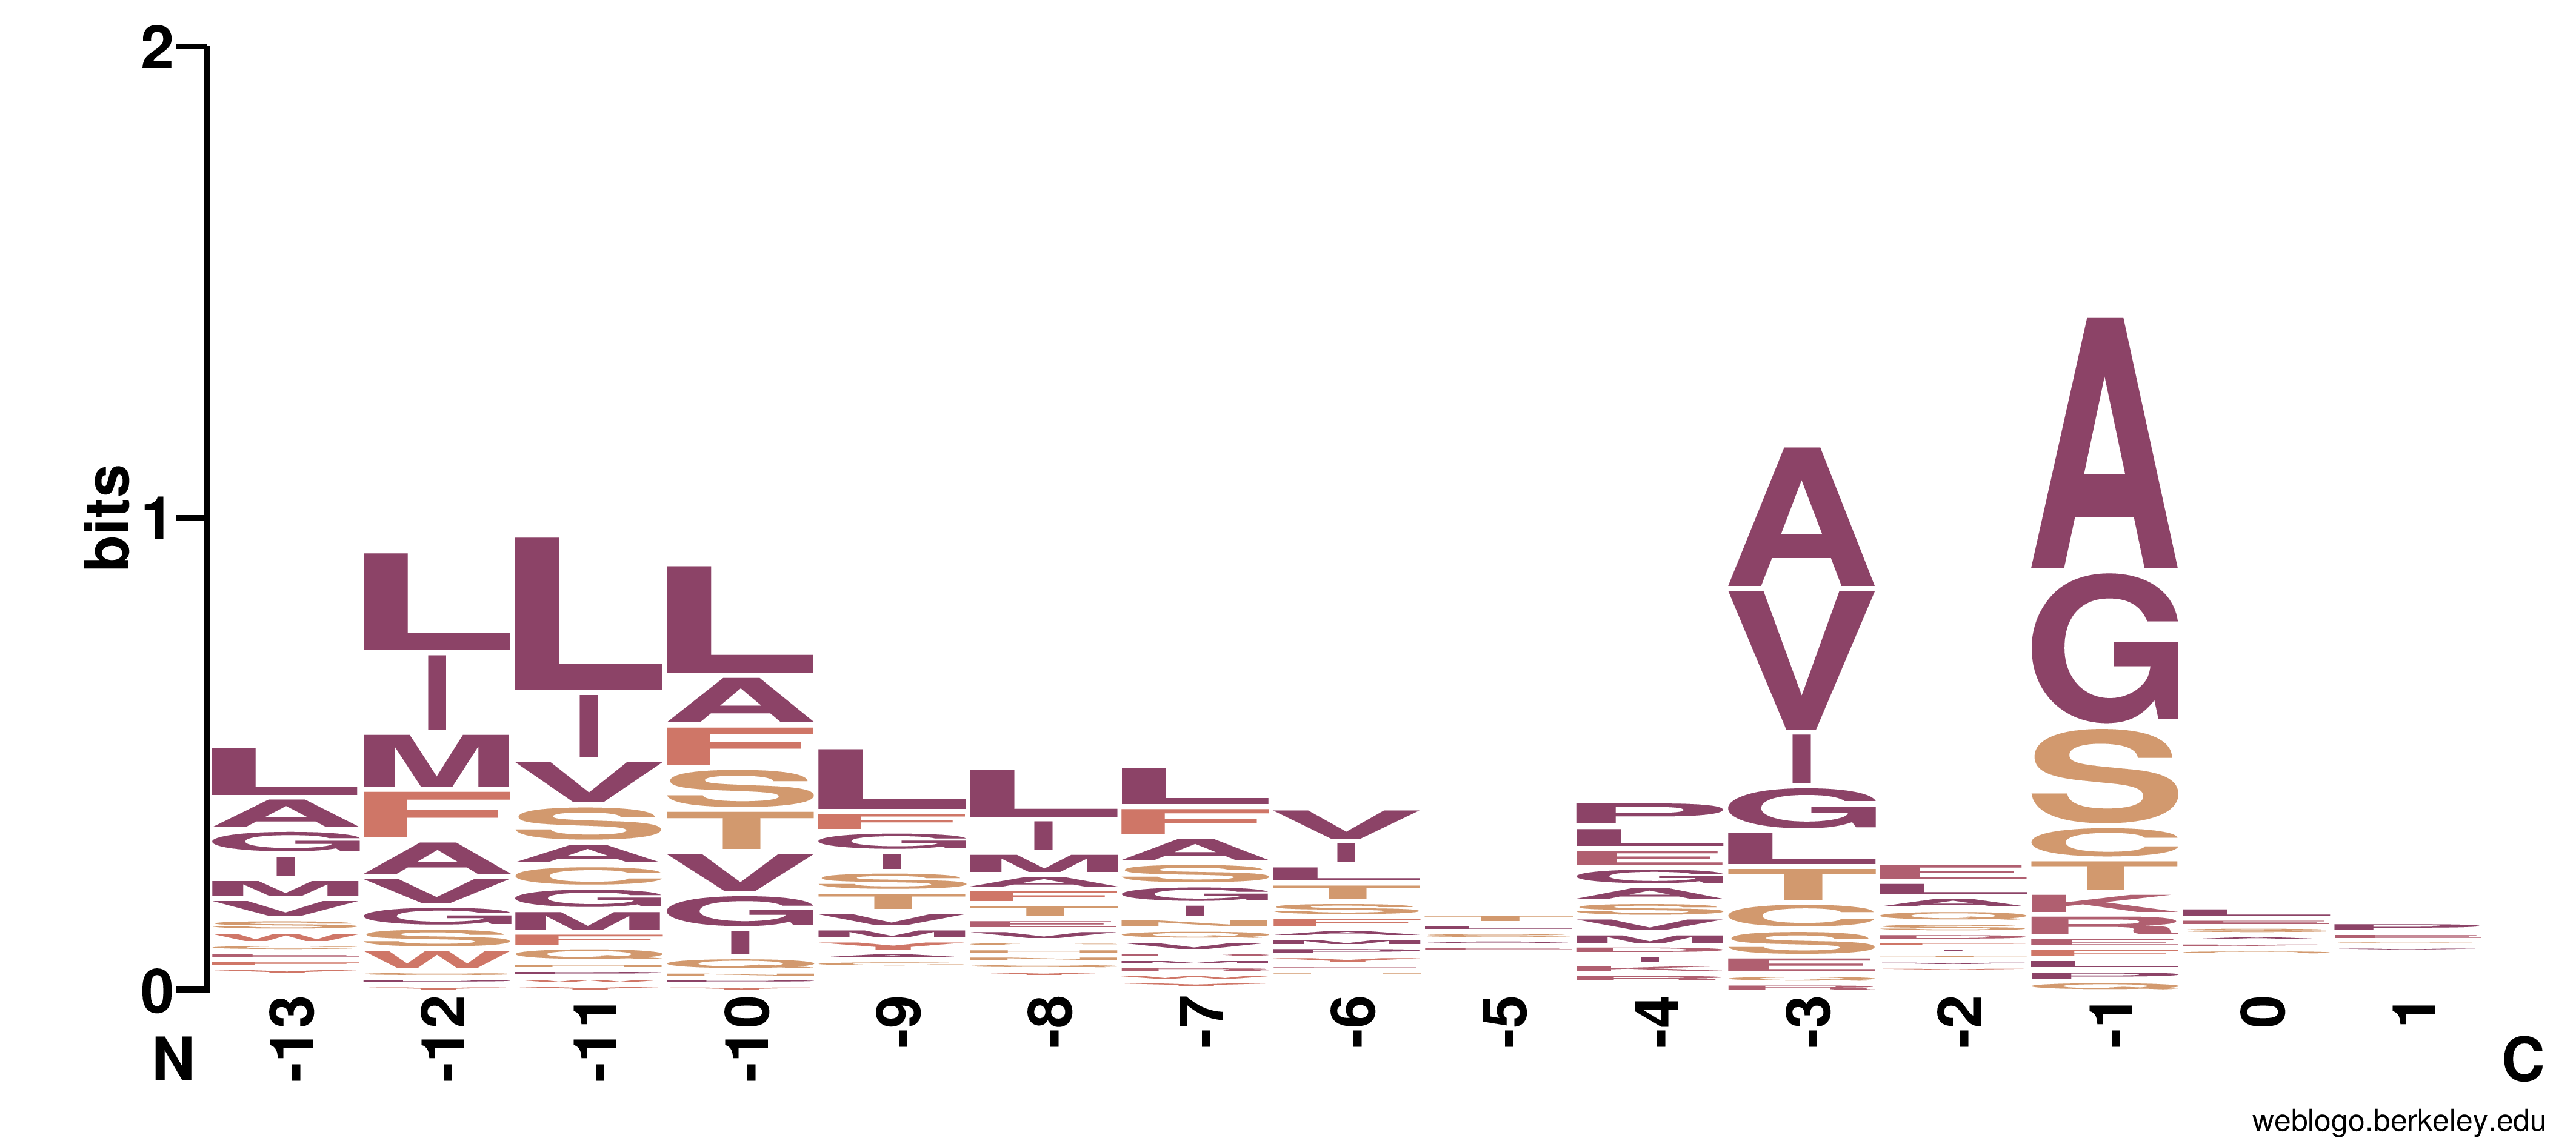